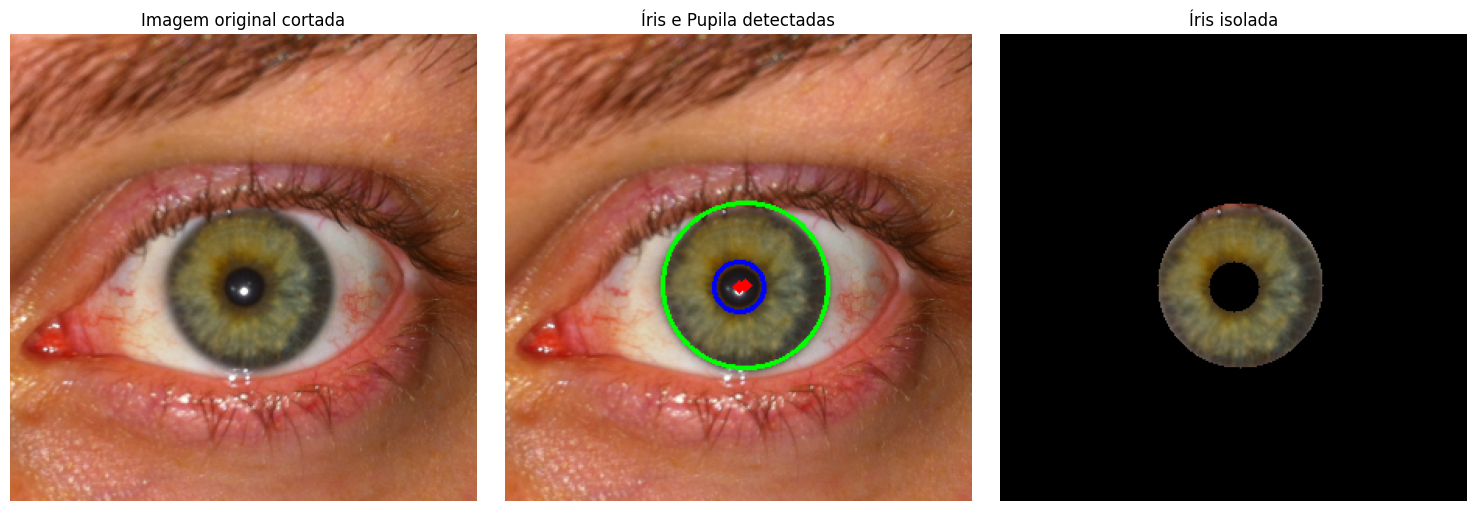

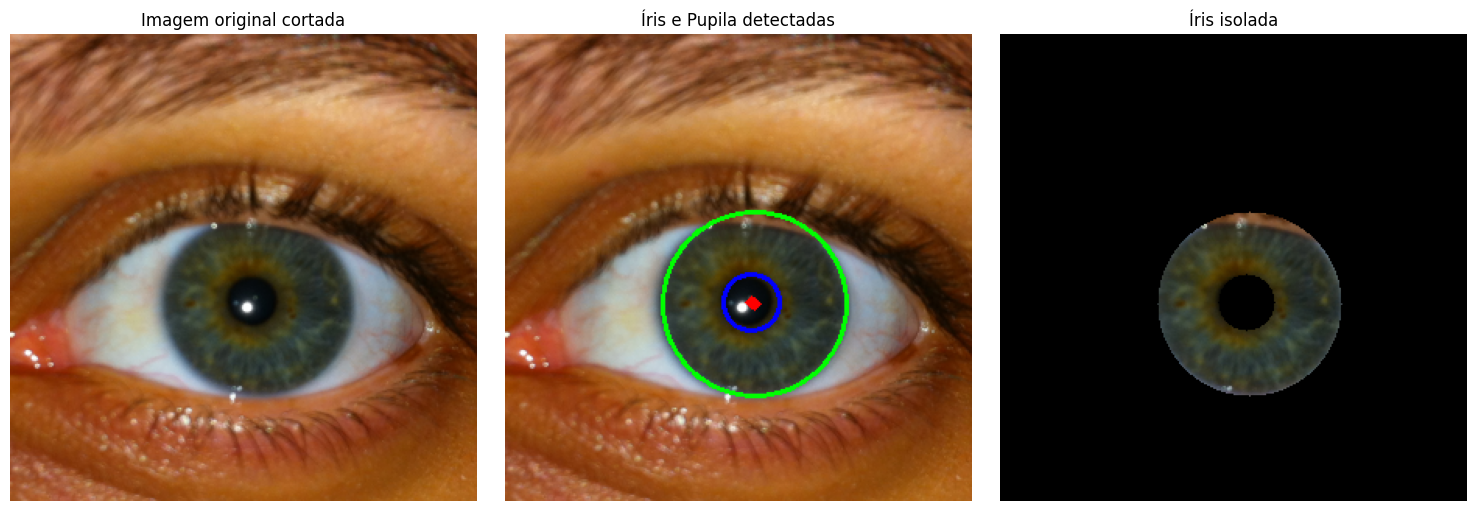

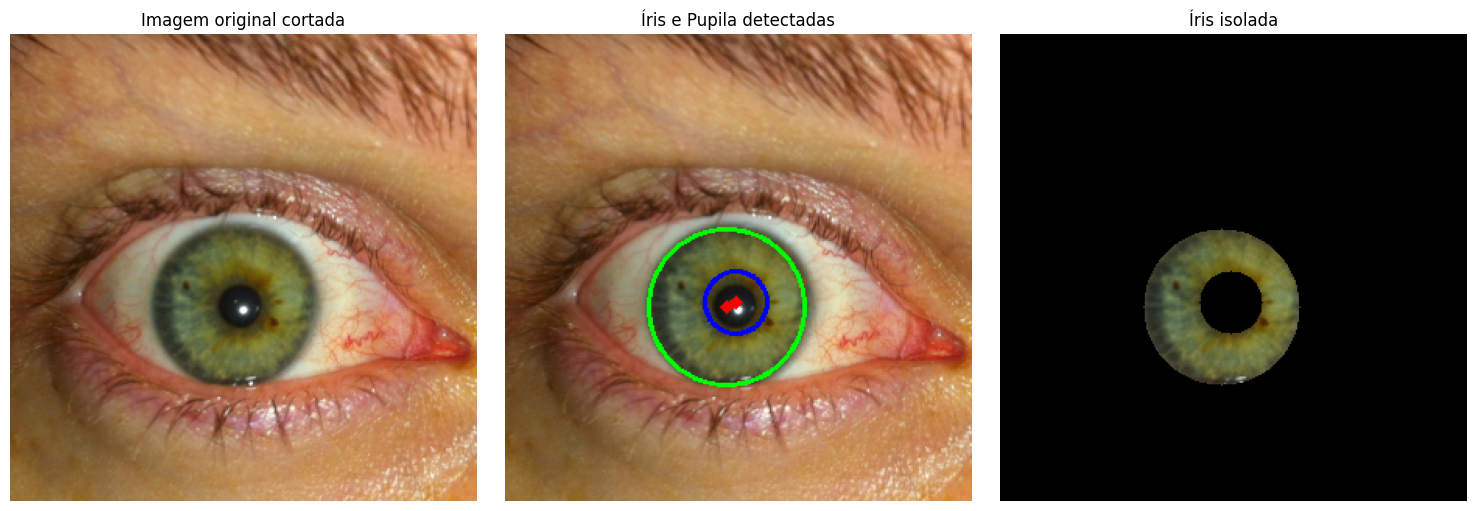

In [1]:
# Maria Júlia Testoni
# Separar a iris

import cv2
import numpy as np
from matplotlib import pyplot as plt

def encontraMelhorThreshold_(roi_gray):
    std = np.std(roi_gray)
    media = np.mean(roi_gray)
    
    if media < 100 and std > 15:
        # Imagem escura e com contraste -> usar inverso
        return 40, cv2.THRESH_BINARY_INV  
    else:
        # Imagem clara ou pouco contraste
        return 63, cv2.THRESH_BINARY

         
lista_imagens = [
    '002_L_03.JPG',
    '004_L_02.JPG',
    '002_R_01.JPG'
]

for nome_imagem in lista_imagens:
    # Reduz a imagem para focar no olho
    img = cv2.imread(nome_imagem)
    desired_width = 800
    scale = desired_width / img.shape[1]
    new_height = int(img.shape[0] * scale)
    diminui_img = cv2.resize(img, (desired_width, new_height), interpolation=cv2.INTER_AREA)
    x, y, w, h = 250, 150, 300, 300 
    img_cortada = diminui_img[y:y+h, x:x+w]
    roi = cv2.cvtColor(img_cortada, cv2.COLOR_BGR2GRAY)

    # ========== Iris =======
    _, threshold = cv2.threshold(roi, 83, 255, cv2.THRESH_BINARY)
    altura_roi, largura_roi = roi.shape
    raio = int(min(altura_roi, largura_roi) / 3)
    min_raio = int(raio * 0.4)
    max_raio = int(raio * 0.9)
    iris = cv2.HoughCircles(threshold, cv2.HOUGH_GRADIENT, 1.5, 150,param1=100, param2=30, minRadius=min_raio, maxRadius=max_raio)
    iris = np.uint16(np.around(iris))

    # ========== Pupila =======
    roi_blur =  cv2.GaussianBlur(roi, (9, 9), 2)
    valor_thresh, tipo_thresh = encontraMelhorThreshold_(roi_blur)
    _, threshold = cv2.threshold(roi_blur, valor_thresh, 255, tipo_thresh)
    min_raio = int(raio * 0.15)
    max_raio = int(raio * 0.35)
    pupila = cv2.HoughCircles(threshold, cv2.HOUGH_GRADIENT, 1.4, 150, param1=150, param2=18, minRadius=min_raio, maxRadius=max_raio)
    pupila = np.uint16(np.around(pupila))

    # ======= Circulos detectados =====
    com_circulos = img_cortada.copy()
    for i in iris[0,:]:
        cv2.circle(com_circulos, (i[0], i[1]), i[2], (0, 255, 0), 2)
        cv2.circle(com_circulos, (i[0], i[1]), 2, (0, 0, 255), 3)
    for i in pupila[0,:]:
        cv2.circle(com_circulos, (i[0], i[1]), i[2], (255, 0, 0), 2)
        cv2.circle(com_circulos, (i[0], i[1]), 2, (0, 0, 255), 3)
        
    # ======= Separa iris da pupila =====
    mask = np.zeros(roi.shape, dtype=np.uint8)
    for c in iris[0, :]:
        cv2.circle(mask, (c[0], c[1]), c[2], 255, -1)
    for c in pupila[0, :]:
        cv2.circle(mask, (c[0], c[1]), c[2], 0, -1)
    iris_color = cv2.bitwise_and(img_cortada, img_cortada, mask=mask)

    # ======= Apresenta =====
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Imagem original cortada")
    plt.imshow(cv2.cvtColor(img_cortada, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Íris e Pupila detectadas")
    plt.imshow(cv2.cvtColor(com_circulos, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Íris isolada")
    plt.imshow(cv2.cvtColor(iris_color, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()